In [1]:
import numpy as np
from numpy import clip
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import os
from diffusers import DDPMScheduler, DDPMPipeline
import pickle 
from torchmetrics.image.fid import FrechetInceptionDistance
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

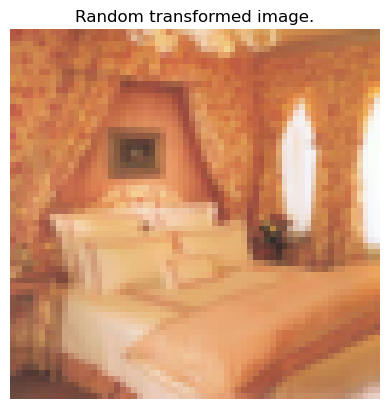

In [3]:
resize_size = 64

transform = transforms.Compose([
    transforms.Resize((resize_size, resize_size)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=GLOBAL_MEAN, std=GLOBAL_STD)
])

data_path = 'data/data0/lsun/bedroom'
batch_size = 32

image_dataset = ImageFolder(root=data_path, transform=transform)
image_dataset = Subset(image_dataset, torch.randperm(len(image_dataset))[:20000])
train_dataloader = DataLoader(image_dataset, batch_size=batch_size, shuffle=True)

for idx, batch in enumerate(train_dataloader):
    break

plt.imshow(batch[0][np.random.randint(0, batch_size)].permute(1, 2, 0))
plt.title("Random transformed image.")
plt.axis('off')
plt.show()

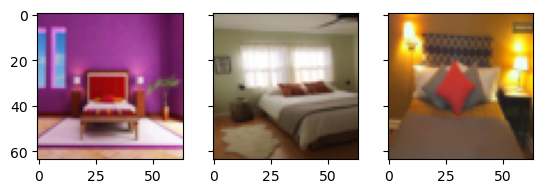

In [4]:
fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True)

axes[0].imshow(batch[0][np.random.randint(0, batch_size)].permute(1, 2, 0))
axes[1].imshow(batch[0][np.random.randint(0, batch_size)].permute(1, 2, 0))
axes[2].imshow(batch[0][np.random.randint(0, batch_size)].permute(1, 2, 0))

In [9]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=64,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # (64, 128, 128, 256)
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

In [10]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

losses = []

In [11]:
for epoch in range(1000):
    for batch in tqdm(train_dataloader, f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        batch = batch[0].to(device)

        noise = torch.randn(batch.shape).to(device)
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (batch.shape[0],), device=batch.device
        ).long()

        noisy_images = noise_scheduler.add_noise(batch, noise, timesteps)
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        loss = F.mse_loss(noise_pred, noise)
        
        loss.backward(loss)
        optimizer.step()

        losses.append(loss.item())
        

    loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

Epoch 1: 100%|██████████| 625/625 [13:50<00:00,  1.33s/it]


Epoch:1, loss: 1.0188981709480285


Epoch 2: 100%|██████████| 625/625 [07:39<00:00,  1.36it/s]


Epoch:2, loss: 1.0081723125457764


Epoch 3: 100%|██████████| 625/625 [07:45<00:00,  1.34it/s]


Epoch:3, loss: 1.00148208360672


Epoch 4: 100%|██████████| 625/625 [07:52<00:00,  1.32it/s]


Epoch:4, loss: 0.9938601690292358


Epoch 5: 100%|██████████| 625/625 [08:25<00:00,  1.24it/s]


Epoch:5, loss: 0.9890960453033447


Epoch 6: 100%|██████████| 625/625 [07:49<00:00,  1.33it/s]


Epoch:6, loss: 0.9869540972709656


Epoch 7: 100%|██████████| 625/625 [07:53<00:00,  1.32it/s]


Epoch:7, loss: 0.9836571093559265


Epoch 8: 100%|██████████| 625/625 [07:54<00:00,  1.32it/s]


Epoch:8, loss: 0.9775190613746643


Epoch 9: 100%|██████████| 625/625 [07:53<00:00,  1.32it/s]


Epoch:9, loss: 0.9743916123390198


Epoch 10: 100%|██████████| 625/625 [08:05<00:00,  1.29it/s]


Epoch:10, loss: 0.9735648348808289


Epoch 11: 100%|██████████| 625/625 [08:47<00:00,  1.18it/s]


Epoch:11, loss: 0.97272686252594


Epoch 12: 100%|██████████| 625/625 [08:50<00:00,  1.18it/s]


Epoch:12, loss: 0.9716445624351502


Epoch 13: 100%|██████████| 625/625 [08:41<00:00,  1.20it/s]


Epoch:13, loss: 0.9690640587806701


Epoch 14: 100%|██████████| 625/625 [08:51<00:00,  1.17it/s]


Epoch:14, loss: 0.9676513055801391


Epoch 15: 100%|██████████| 625/625 [08:46<00:00,  1.19it/s]


Epoch:15, loss: 0.9664818947792053


Epoch 16: 100%|██████████| 625/625 [08:48<00:00,  1.18it/s]


Epoch:16, loss: 0.9657723494529724


Epoch 17: 100%|██████████| 625/625 [08:43<00:00,  1.19it/s]


Epoch:17, loss: 0.9653994827270508


Epoch 18: 100%|██████████| 625/625 [08:46<00:00,  1.19it/s]


Epoch:18, loss: 0.9649824790000916


Epoch 19: 100%|██████████| 625/625 [08:53<00:00,  1.17it/s]


Epoch:19, loss: 0.9645556631088257


Epoch 20: 100%|██████████| 625/625 [08:42<00:00,  1.20it/s]


Epoch:20, loss: 0.96466691198349


Epoch 21: 100%|██████████| 625/625 [09:06<00:00,  1.14it/s]


Epoch:21, loss: 0.9639728289604187


Epoch 22: 100%|██████████| 625/625 [08:52<00:00,  1.17it/s]


Epoch:22, loss: 0.9639039653778076


Epoch 23: 100%|██████████| 625/625 [09:07<00:00,  1.14it/s]  


Epoch:23, loss: 0.9631625982284546


Epoch 24: 100%|██████████| 625/625 [08:45<00:00,  1.19it/s]


Epoch:24, loss: 0.9622879239082336


Epoch 25: 100%|██████████| 625/625 [08:38<00:00,  1.20it/s]


Epoch:25, loss: 0.9619667046546936


Epoch 26: 100%|██████████| 625/625 [08:41<00:00,  1.20it/s]


Epoch:26, loss: 0.9635841093063354


Epoch 27: 100%|██████████| 625/625 [08:41<00:00,  1.20it/s]


Epoch:27, loss: 0.9769872130393982


Epoch 28: 100%|██████████| 625/625 [08:42<00:00,  1.20it/s]


Epoch:28, loss: 0.9713429014205932


Epoch 29:  38%|███▊      | 236/625 [03:20<05:30,  1.18it/s]


KeyboardInterrupt: 

In [301]:
# with open("model.pickle", "wb") as f:
#     pickle.dump(model, f)

In [10]:
# with open("model.pickle", "rb") as f:
#     a = pickle.load(f)

In [12]:
def min_max_array(array):
    try:
        array = array.numpy()
    except:
        pass
    min_vals = np.reshape(np.min(array, axis=(2, 3)), (array.shape[0], 3, 1, 1))
    max_vals = np.reshape(np.max(array, axis=(2, 3)), (array.shape[0], 3, 1, 1))

    return (array - min_vals) / (max_vals - min_vals)

In [13]:
def plot_images(sample, name):
    fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(6, 6))
    scaled = min_max_array(np.array(sample.cpu()))
    scaled = np.transpose(scaled, (0, 2, 3, 1))
    for ind in range(9):
        axes[(ind)//3, (ind)%3].imshow(scaled[ind])
        axes[(ind)//3, (ind)%3].axis('off')
    fig.suptitle(name)
    plt.show()
    return scaled

In [14]:
init_sample = torch.randn(9, 3, 64, 64).to(device)
sample = torch.clone(init_sample)

for t in tqdm(noise_scheduler.timesteps, "Denoising images..."):
    with torch.no_grad():
        residual = model(sample, t).sample
    sample = noise_scheduler.step(residual, t, sample).prev_sample

Denoising images...: 100%|██████████| 1000/1000 [01:11<00:00, 14.05it/s]


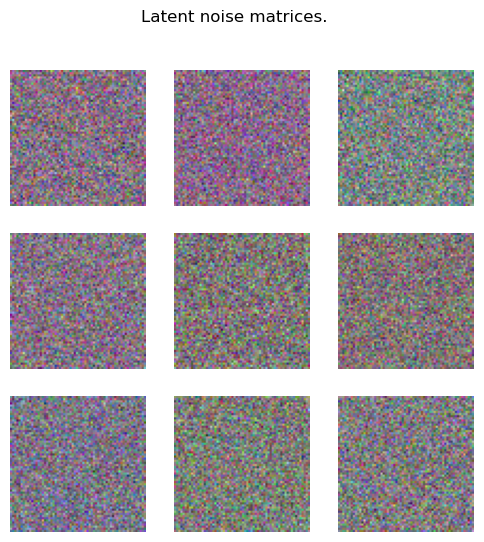

In [15]:
scaled_latent = plot_images(init_sample, "Latent noise matrices.")

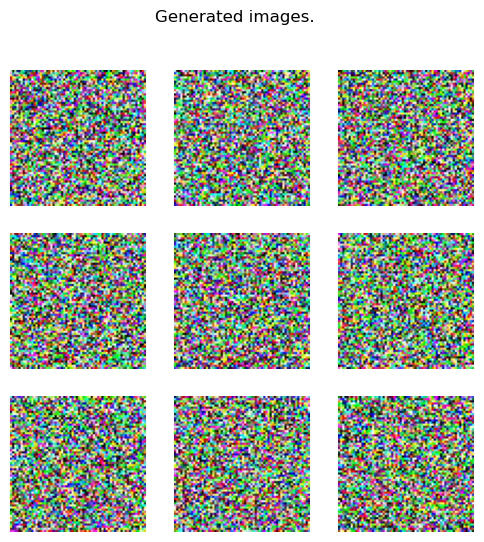

In [16]:
scaled_sample = plot_images(sample, "Generated images.")

In [17]:
fid_list = []
for i in tqdm(range(10), "Calculating avg FID..."):
    for idx, test_batch in enumerate(train_dataloader):
        break

    fid = FrechetInceptionDistance(feature=64)
    fid.update((test_batch[0][:9]*255).to(torch.uint8), real=True)
    fid.update((torch.from_numpy(scaled_sample).permute(0, 3, 2, 1)*255).to(torch.uint8), real=False)
    fid_list.append(fid.compute().item())

Calculating avg FID...: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


In [18]:
print(f"Averaged FID score for 10 random true image batches and generated sample is {np.average(fid_list)}.")

Averaged FID score for 10 random true image batches and generated sample is 440.57866821289065.


In [46]:
IND_ONE, IND_TWO = 0, 3
for i in range(9):
    p = np.random.uniform(0, 1)
    if i == 0:
        comb_latent = np.expand_dims((p * scaled_latent[IND_ONE]) + ((1-p) * scaled_latent[IND_TWO]), 0)
    else:
        new_comb = np.expand_dims((p * scaled_latent[IND_ONE]) + ((1-p) * scaled_latent[IND_TWO]), 0)
        comb_latent = np.concatenate((comb_latent, new_comb), axis=0)

comb_latent = torch.from_numpy(comb_latent).to(device).permute(0, 3, 2, 1)

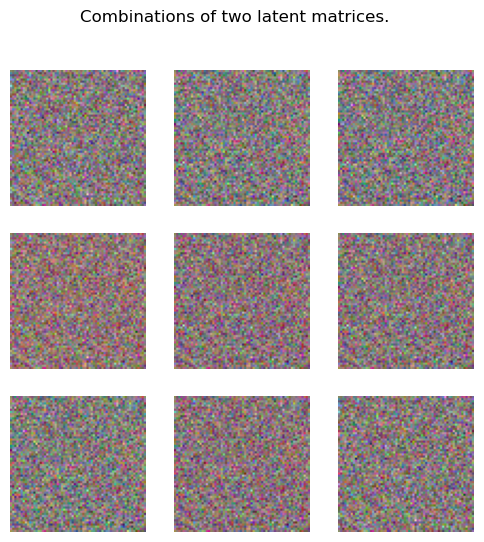

In [47]:
scaled_comb_latent = plot_images(comb_latent, "Combinations of two latent matrices.")

In [48]:
comb_input = torch.clone(comb_latent)

for t in tqdm(noise_scheduler.timesteps, "Denoising images..."):
    with torch.no_grad():
        residual = model(comb_input, t).sample
    comb_input = noise_scheduler.step(residual, t, comb_input).prev_sample

Denoising images...: 100%|██████████| 1000/1000 [01:11<00:00, 13.97it/s]


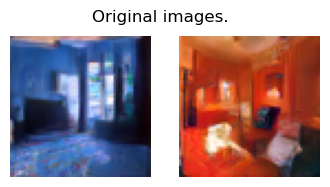

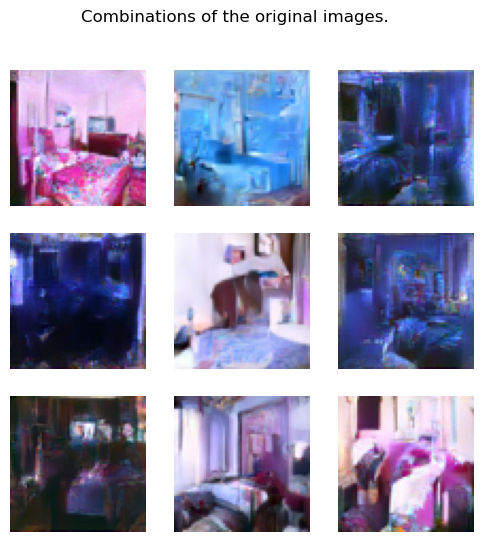

In [49]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(4, 2))

axes[0].imshow(scaled_sample[IND_ONE])
axes[0].axis('off')

axes[1].imshow(scaled_sample[IND_TWO])
axes[1].axis('off')

fig.suptitle("Original images.")

scaled_comb_sample = plot_images(comb_input, "Combinations of the original images.")